# Image Generation via Generative Adversarial Networks

## import libraries

In [35]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
directory_data  = '/content/drive/MyDrive/2022_ml_assignment/'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [38]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [39]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

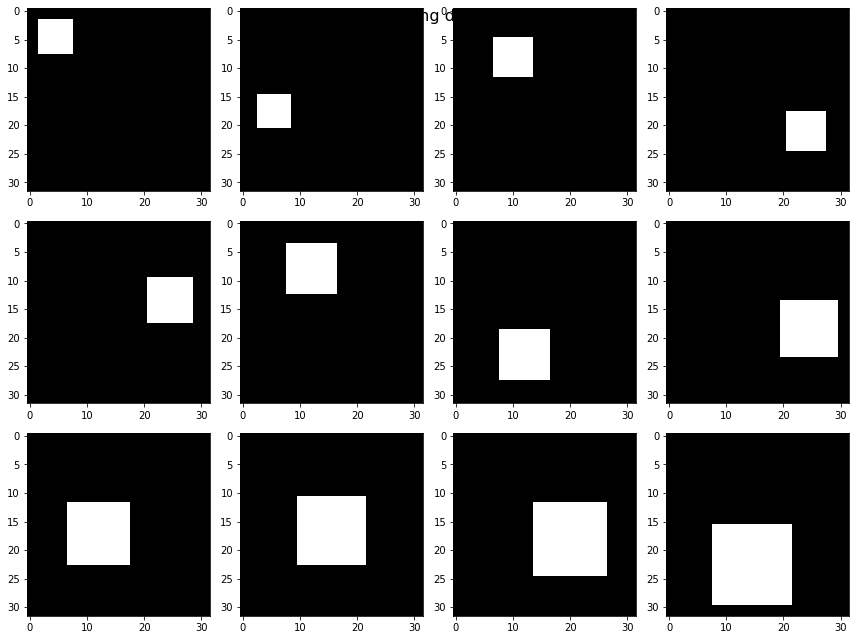

In [40]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [41]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
print(device)

cuda


## construct datasets and dataloaders 

In [44]:
size_minibatch  = 128
dim_latent      = 64

dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

In [45]:
# check
for x in dataloader_real:
    print(x.shape)
    break

torch.Size([128, 1, 32, 32])


## neural networks 

In [46]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [47]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # self.linear1 = nn.Linear(32*32, 512)
        # self.linear2 = nn.Linear(512, 256)
        # self.linear3 = nn.Linear(256, 1)
        # self.leaky_relu = nn.LeakyReLU(0.2)
        # self.sigmoid = nn.Sigmoid()

        # self.initialize_weight()
        self.noise = 64
        self.fmsize = 32 

        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # nn.Conv2d(1, self.fmsize, 4, 2, 1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(1, self.fmsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.fmsize * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(self.fmsize * 2, self.fmsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.fmsize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(self.fmsize * 4, self.fmsize * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.fmsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(self.fmsize * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        # x = x.view(x.size(0), -1)
        # x = self.leaky_relu(self.linear1(x))
        # x = self.leaky_relu(self.linear2(x))
        # x = self.linear3(x)
        # x = self.sigmoid(x)
        # return x
        return self.main(x)

    # def initialize_weight(self):
            
    #     for m in self.modules():
            
    #         if isinstance(m, nn.Conv2d):

    #             # nn.init.xavier_uniform_(m.weight) 
    #             nn.init.normal_(m.weight.data, 0.0, 0.02)
    #             if m.bias is not None:

    #                 nn.init.constant_(m.bias, 1)
    #                 pass
                    
    #         elif isinstance(m, nn.BatchNorm2d):
                
    #             # nn.init.constant_(m.weight, 1)
    #             # nn.init.constant_(m.bias, 1)
    #             nn.init.normal_(m.weight.data, 1.0, 0.02)
    #             nn.init.constant_(m.bias.data, 0)
                
    #         elif isinstance(m, nn.Linear):

    #             nn.init.xavier_uniform_(m.weight)

    #             if m.bias is not None:
                    
    #                 nn.init.constant_(m.bias, 1)
    #                 pass

In [48]:
# check
tempx = torch.randn(20,1,32,32).to(device)
model_dis = Discriminator().to(device)
model_dis.apply(weights_init)
output = model_dis(tempx)
print(output.shape)

torch.Size([20, 1, 1, 1])


In [49]:
class Generator(nn.Module): 
    def __init__(self):
        super(Generator, self).__init__()

        # self.linear1 = nn.Linear(64, 128)
        # self.linear2 = nn.Linear(128, 256)
        # self.linear3 = nn.Linear(256, 512)
        # self.linear4 = nn.Linear(512, 32*32)
        # self.relu = nn.LeakyReLU(0.2)
        # self.sigmoid = nn.Sigmoid()
        self.noise = 64
        self.fmsize = 32
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( self.noise , self.fmsize * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.fmsize * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.fmsize * 8, self.fmsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.fmsize * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( self.fmsize * 4, self.fmsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.fmsize * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            # nn.ConvTranspose2d( self.fmsize * 2, self.fmsize, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(self.fmsize),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( self.fmsize * 2, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        # x = self.relu(self.linear1(x))
        # x = self.relu(self.linear2(x))
        # x = self.relu(self.linear3(x))
        # x = self.linear4(x)
        # x = self.sigmoid(x)
        # x = x.view(x.size(0), *(1,32,32))
        # return x
        return self.main(x)

In [50]:
#check
tempx = torch.randn(20,64,1,1).to(device) # random noise
model_gen = Generator().to(device)
model_gen.apply(weights_init)
output = model_gen(tempx) # noise를 입력받아 이미지 생성
# output = output.view(output.size(0), *(1,32,32))
print(output.shape)

torch.Size([20, 1, 32, 32])


## build network

In [51]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)

## compute the prediction

In [52]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [53]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
    
    return bounding_mask

In [54]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

In [55]:
# Initialize BCELoss function
criterion = nn.BCELoss()
learning_rate = 0.0001
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5


# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [56]:
aaa = torch.Tensor(10,1,1,1)
print(aaa.shape)
aaa = aaa.view(-1)
print(aaa.shape)

torch.Size([10, 1, 1, 1])
torch.Size([10])


## train

In [85]:
def train(generator, discriminator, dataloader):
    
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        print("real", real.shape)
        size_batch  = len(real)
        #노이즈 생성
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])
        # print(latent.shape)
        
        # 라벨을 만들어 줍니다. 1 for real, 0 for fake
        # real_label = torch.Tensor(size_batch,1).fill_(1.0).to(device)
        # fake_label = torch.Tensor(size_batch,1).fill_(0.0).to(device)
        label = torch.full((size_batch,), real_label, dtype=torch.float, device=device)
        
        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()
        # Initialize grad
        g_optimizer.zero_grad()
      

        # fake image를 generator와 noize vector 'z' 를 통해 만들어주기
        label.fill_(real_label)
        fake_images = generator(latent)
        output = discriminator(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()

        g_optimizer.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()

        # Initialize grad
        d_optimizer.zero_grad()
        print("1166")
        # generator와 noise vector 'z'로 fake image 생성
        label.fill_(real_label)
        output = discriminator(real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        print("1155")
        # fake_images = generator(latent)
        label.fill_(fake_label)
        print("1144")
        fake_images2 = generator(latent)
        output = discriminator(fake_images2).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        # print("fake", fake_images.shape)
        print("1133")
        # loss function에 fake image와 real 넘겨주기
        # 만약 generator가 discriminator를 속이면, g_loss가 줄어든다.
        print("1122")
        # backpropagation를 통해 generator 학습
        # errD_fake.backward(retain_graph=True)
        # errD = errD_real + errD_fake
        print("11")
        
        print("111")
        d_optimizer.step()
        print("1111")
        

        # # fake image와 fake label, real image와 real label을 넘겨 loss 계산
        # fake_loss = criterion(discriminator(fake_images), fake_label)
        # real_loss = criterion(discriminator(real), real_label)
        # d_loss = (fake_loss + real_loss) / 2
        # # backpropagation을 통해 discriminator 학습
        # # 이 부분에서는 generator는 학습시키지 않음
        # d_loss.backward()
        # d_optimizer.step()

## test

In [58]:
def test(generator, latent):
    
    generator.eval()
    
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [86]:
number_epoch    = 200
accuracy_epoch  = np.zeros(number_epoch)

num_latent_test = 100
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1])

for i in tqdm(range(number_epoch)):
    train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy

  0%|          | 0/20 [00:00<?, ?it/s]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real t

  5%|▌         | 1/20 [00:01<00:27,  1.43s/it]

1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1

 10%|█         | 2/20 [00:02<00:24,  1.39s/it]

1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1

 15%|█▌        | 3/20 [00:04<00:23,  1.37s/it]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real t

 20%|██        | 4/20 [00:05<00:21,  1.37s/it]

1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1

 25%|██▌       | 5/20 [00:06<00:20,  1.36s/it]

1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1

 30%|███       | 6/20 [00:08<00:19,  1.36s/it]

1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1

 35%|███▌      | 7/20 [00:09<00:17,  1.36s/it]

1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
r

 40%|████      | 8/20 [00:10<00:16,  1.36s/it]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real t

 45%|████▌     | 9/20 [00:12<00:14,  1.36s/it]

1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1

 50%|█████     | 10/20 [00:13<00:13,  1.36s/it]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real t

 55%|█████▌    | 11/20 [00:14<00:12,  1.36s/it]

1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1

 60%|██████    | 12/20 [00:16<00:10,  1.36s/it]

1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1

 65%|██████▌   | 13/20 [00:17<00:09,  1.35s/it]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real t

 70%|███████   | 14/20 [00:19<00:08,  1.35s/it]

1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1

 75%|███████▌  | 15/20 [00:20<00:06,  1.36s/it]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real t

 80%|████████  | 16/20 [00:21<00:05,  1.36s/it]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real t

 85%|████████▌ | 17/20 [00:23<00:04,  1.36s/it]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real t

 90%|█████████ | 18/20 [00:24<00:02,  1.36s/it]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real t

 95%|█████████▌| 19/20 [00:25<00:01,  1.36s/it]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111
real t

100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

real torch.Size([128, 1, 32, 32])
1166
1155
1144
1133
1122
11
111
1111


---

# functions for presenting the results

---

In [87]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [88]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [89]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



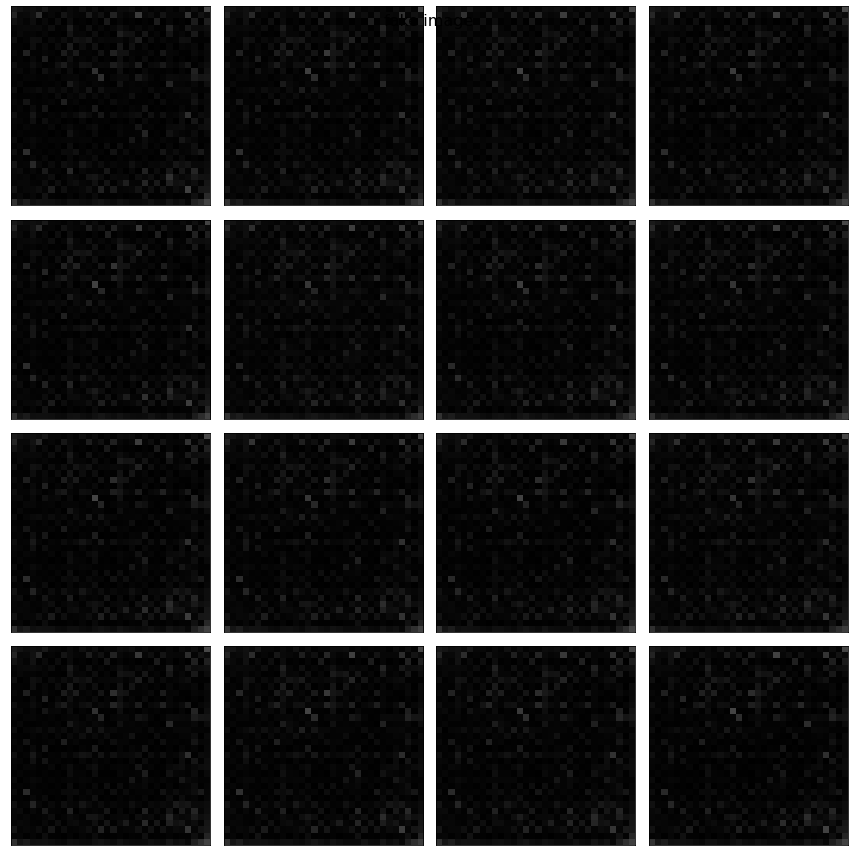

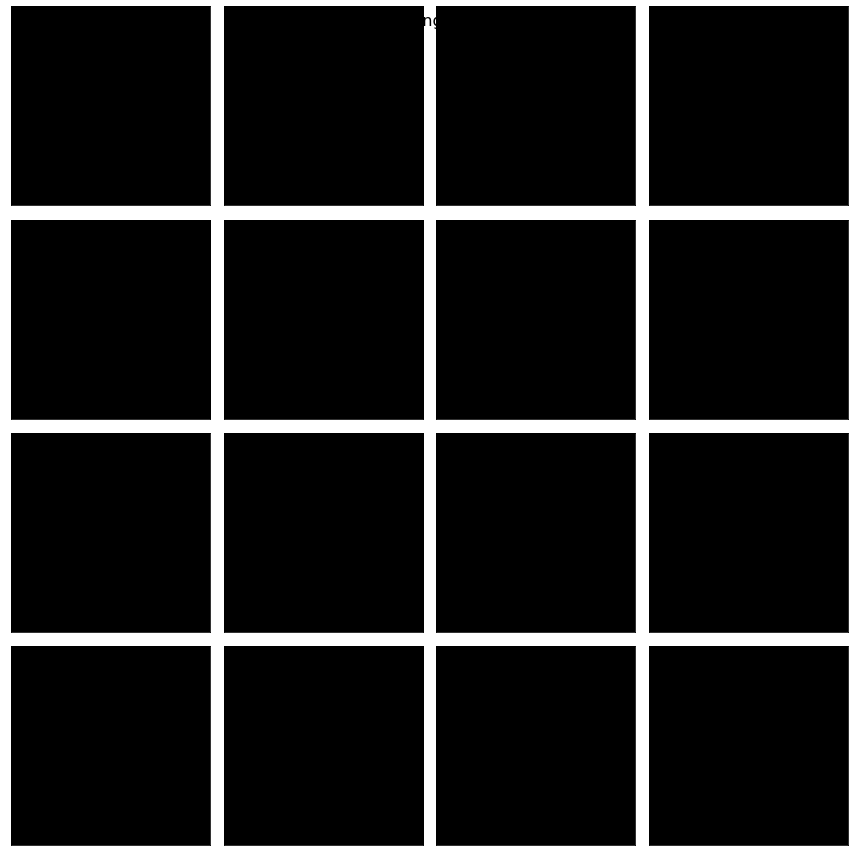


################################################################################
#
# RESULT # 02
#
################################################################################



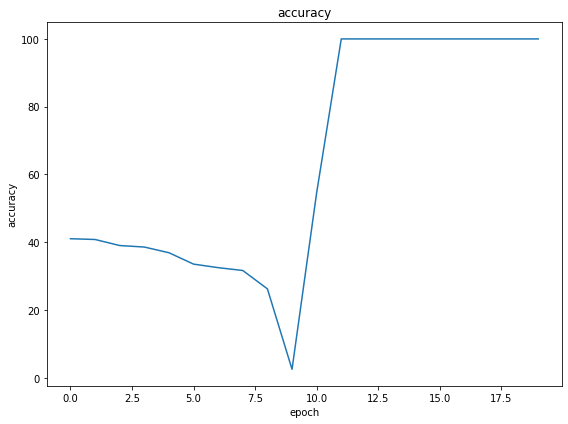


################################################################################
#
# RESULT # 03
#
################################################################################

final accuracy = 100.00000000


In [90]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)